# Generate and Perform Tiny Performances from the MDRNN

### Imports and Utility Functions

Functions are provided to generate performances of a certain length, plot, and perform them.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
# little path hack to get robojam from one directory up in the filesystem.
from context import * # imports robojam
# import robojam # alternatively do this.

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Plotting Methods

Mainly using "plot_and_perform" method to generate 2D and 3D plots.

In [66]:
input_colour = 'darkblue'
gen_colour = 'firebrick'
plt.style.use('seaborn-talk')

osc_client = robojam.TouchScreenOscClient()

def plot_2D(perf_df, name="foo", saving=False):
    """Plot in 2D"""
    ## Plot the performance
    swipes = divide_performance_into_swipes(perf_df)
    plt.figure(figsize=(8, 8))
    for swipe in swipes:
        p = plt.plot(swipe.x, swipe.y, 'o-')
        plt.setp(p, color=gen_colour, linewidth=5.0)
    plt.ylim(1.0,0)
    plt.xlim(0,1.0)
    plt.xticks([])
    plt.yticks([])
    if saving:
        plt.savefig(name+".png", bbox_inches='tight')
        plt.close()
    else:
        plt.show()

def plot_double_2d(perf1, perf2, name="foo", saving=False):
    """Plot two performances in 2D"""
    plt.figure(figsize=(8, 8))
    swipes = divide_performance_into_swipes(perf1)
    for swipe in swipes:
        p = plt.plot(swipe.x, swipe.y, 'o-')
        plt.setp(p, color=input_colour, linewidth=5.0)
    swipes = divide_performance_into_swipes(perf2)
    for swipe in swipes:
        p = plt.plot(swipe.x, swipe.y, 'o-')
        plt.setp(p, color=gen_colour, linewidth=5.0)
    plt.ylim(1.0,0)
    plt.xlim(0,1.0)
    plt.xticks([])
    plt.yticks([])
    if saving:
        plt.savefig(name+".png", bbox_inches='tight')
        plt.close()
    else:
        plt.show()

def plot_3D(perf_df, name="foo", saving=False):
    """Plot in 3D"""
    ## Plot in 3D
    swipes = divide_performance_into_swipes(perf_df)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for swipe in swipes:
        p = ax.plot(list(swipe.index), list(swipe.x), list(swipe.y), 'o-')
        plt.setp(p, color=gen_colour, linewidth=5.0)
    ax.set_ylim(0,1.0)
    ax.set_zlim(1.0,0)
    ax.set_xlabel('time (s)')
    ax.set_ylabel('x')
    ax.set_zlabel('y')
    if saving:
        plt.savefig(name+".png", bbox_inches='tight')
        plt.close()
    else:
        plt.show()
        
def plot_double_3d(perf1, perf2, name="foo", saving=False):
    """Plot two performances in 3D"""
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    swipes = divide_performance_into_swipes(perf1)
    for swipe in swipes:
        p = ax.plot(list(swipe.index), list(swipe.x), list(swipe.y), 'o-')
        plt.setp(p, color=input_colour, linewidth=5.0)
    swipes = divide_performance_into_swipes(perf2)
    for swipe in swipes:
        p = ax.plot(list(swipe.index), list(swipe.x), list(swipe.y), 'o-')
        plt.setp(p, color=gen_colour, linewidth=5.0)
    ax.set_ylim(0,1.0)
    ax.set_zlim(1.0,0)
    ax.set_xlabel('time (s)')
    ax.set_ylabel('x')
    ax.set_zlabel('y')
    if saving:
        plt.savefig(name+".png", bbox_inches='tight')
        plt.close()
    else:
        plt.show()
        
def plot_and_perform_sequentially(perf1, perf2, perform=True):
    total = np.append(perf1, perf2, axis=0)
    total = total.T
    perf1 = perf1.T
    perf2 = perf2.T
    perf1_df = pd.DataFrame({'x':perf1[0], 'y':perf1[1], 't':perf1[2]})
    perf2_df = pd.DataFrame({'x':perf2[0], 'y':perf2[1], 't':perf2[2]})
    total_df = pd.DataFrame({'x':total[0], 'y':total[1], 't':total[2]})
    perf1_df['time'] = perf1_df.t.cumsum()
    total_perf1_time = perf1_df.t.sum()
    perf2_df['time'] = perf2_df.t.cumsum() + total_perf1_time
    total_df['time'] = total_df.t.cumsum()
    ## Plot the performances
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(perf1_df.time, perf1_df.x, perf1_df.y, '.b-')
    ax.plot(perf2_df.time, perf2_df.x, perf2_df.y, '.r-')
    plt.show()
    if perform:
        osc_client.playPerformance(total_df)
        
def divide_performance_into_swipes(perf_df):
    """Divides a performance into a sequence of swipe dataframes."""
    touch_starts = perf_df[perf_df.moving == 0].index
    performance_swipes = []
    remainder = perf_df
    for att in touch_starts:
        swipe = remainder.iloc[remainder.index < att]
        performance_swipes.append(swipe)
        remainder = remainder.iloc[remainder.index >= att]
    performance_swipes.append(remainder)
    return performance_swipes

## Generate and play a performance

Performances are generated using the `generate_random_tiny_performance` method which is set to produce performances up to 5 seconds. The LSTM state and first touch can optionally be kept from the last evaluation or re-initialised.

This block can be run multiple times to generate more performances.

INFO:tensorflow:Loading Running Operations
INFO:tensorflow:done initialising: mdrnn-2d-1d-3layers-512units-16mixtures vars: 5329040
INFO:tensorflow:Restoring parameters from ../models/mdrnn-2d-1d-3layers-512units-16mixtures


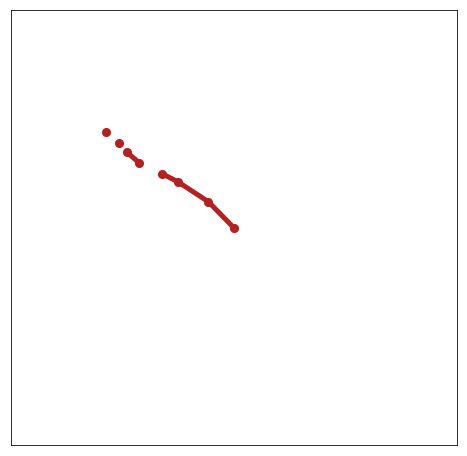

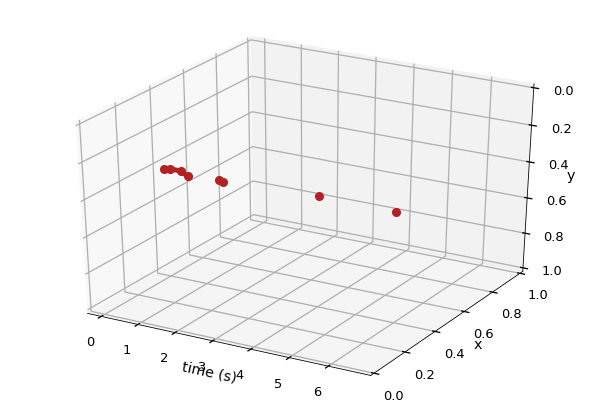

In [84]:
# Generate and play one unconditioned performance
# Hyperparameters:
HIDDEN_UNITS = 512
LAYERS = 3
MIXES = 16
# Network
net = robojam.MixtureRNN(mode=robojam.NET_MODE_RUN, n_hidden_units=HIDDEN_UNITS, n_mixtures=MIXES, batch_size=1, sequence_length=1, n_layers=LAYERS)
osc_client.setSynth(instrument = "chirp")
model_file = "../models/mdrnn-2d-1d-3layers-512units-16mixtures"
TEMPERATURE = 1.00
# Generate
perf = robojam.generate_random_tiny_performance(net, np.array([0.5, 0.5, 0.1]), time_limit=5.0, temp=TEMPERATURE, model_file=model_file)
# Plot and perform.
perf_df = robojam.perf_array_to_df(perf)

plot_2D(perf_df, saving=False)
plot_3D(perf_df, saving=False)
osc_client.playPerformance(perf_df)

In [58]:
## Generate a number of unconditioned performances
NUMBER = 10

# Hyperparameters:
HIDDEN_UNITS = 512
LAYERS = 3
MIXES = 16
net = robojam.MixtureRNN(mode=robojam.NET_MODE_RUN, n_hidden_units=HIDDEN_UNITS, n_mixtures=MIXES, batch_size=1, sequence_length=1, n_layers=LAYERS)
# Setup synth for performance
osc_client.setSynth(instrument = "chirp")
model_file = "../models/mdrnn-2d-1d-3layers-512units-16mixtures"
TEMPERATURE = 1.00

for i in range(NUMBER):
    name = "touchperf-uncond-" + str(i)
    net.state = None # reset state if needed.
    perf = robojam.generate_random_tiny_performance(net, np.array([0.5, 0.5, 0.1]), time_limit=5.0, temp=TEMPERATURE, model_file=model_file)
    perf_df = robojam.perf_array_to_df(perf)
    plot_2D(perf_df, name=name, saving=True)

INFO:tensorflow:Loading Running Operations
INFO:tensorflow:done initialising: mdrnn-2d-1d-3layers-512units-16mixtures vars: 5329040
INFO:tensorflow:Restoring parameters from ../models/mdrnn-2d-1d-3layers-512units-16mixtures
INFO:tensorflow:Restoring parameters from ../models/mdrnn-2d-1d-3layers-512units-16mixtures
INFO:tensorflow:Restoring parameters from ../models/mdrnn-2d-1d-3layers-512units-16mixtures
INFO:tensorflow:Restoring parameters from ../models/mdrnn-2d-1d-3layers-512units-16mixtures
INFO:tensorflow:Restoring parameters from ../models/mdrnn-2d-1d-3layers-512units-16mixtures
INFO:tensorflow:Restoring parameters from ../models/mdrnn-2d-1d-3layers-512units-16mixtures
INFO:tensorflow:Restoring parameters from ../models/mdrnn-2d-1d-3layers-512units-16mixtures
INFO:tensorflow:Restoring parameters from ../models/mdrnn-2d-1d-3layers-512units-16mixtures
INFO:tensorflow:Restoring parameters from ../models/mdrnn-2d-1d-3layers-512units-16mixtures
INFO:tensorflow:Restoring parameters fro

# Condition and Generate

Conditions the MDRNN on a random touchscreen performance, then generates a 5 second response.

This requires example performances (`.csv` format) to be in `../performances`. 
See `TinyPerformanceLoader` for more details.



In [85]:
# Load the sample touchscreen performances:
loader = robojam.TinyPerformanceLoader(verbose=False)
# Fails if example performances are not in ../performance

INFO:tensorflow:Loading Running Operations
INFO:tensorflow:done initialising: mdrnn-2d-1d-3layers-512units-16mixtures vars: 5329040
INFO:tensorflow:Restoring parameters from ../models/mdrnn-2d-1d-3layers-512units-16mixtures


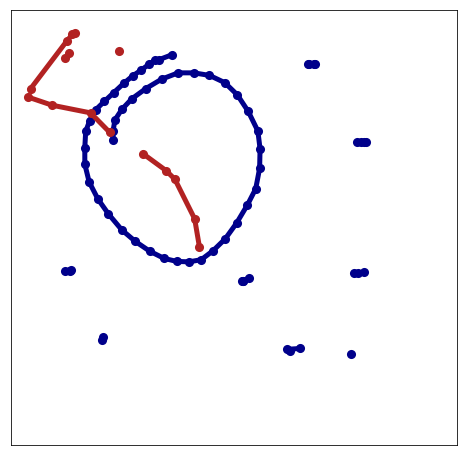

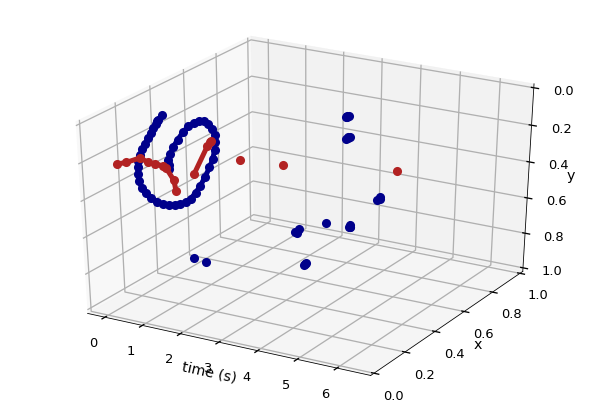

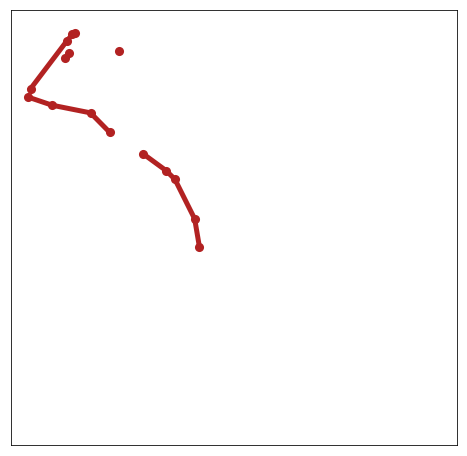

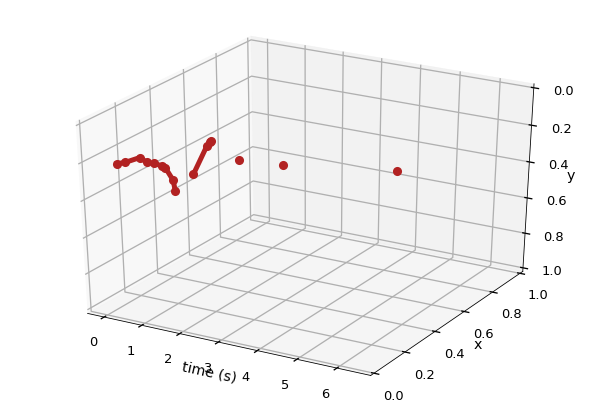

In [68]:
# Generate and play one conditioned performance
# Hyperparameters:
HIDDEN_UNITS = 512
LAYERS = 3
MIXES = 16
net = robojam.MixtureRNN(mode=robojam.NET_MODE_RUN, n_hidden_units=HIDDEN_UNITS, n_mixtures=MIXES, batch_size=1, sequence_length=1, n_layers=LAYERS)
# Setup synth for performance
osc_client.setSynth(instrument = "chirp")
model_file = "../models/mdrnn-2d-1d-3layers-512units-16mixtures"
TEMPERATURE = 1.00
in_df = loader.sample_without_replacement(n=1)[0]

in_array = robojam.perf_df_to_array(in_df)
output_perf = robojam.condition_and_generate(net, in_array, time_limit=5.0, temp=TEMPERATURE, model_file=model_file)
out_df = robojam.perf_array_to_df(output_perf)

# Plot and perform
plot_double_2d(in_df, out_df)
plot_double_3d(in_df, out_df)

# just perform the output...
plot_and_perform(out_df)

# TODO: implement polyphonic playback. Somehow.

In [69]:
# Generate a number of conditioned performances.
NUMBER = 10

# Hyperparameters:
HIDDEN_UNITS = 512
LAYERS = 3
MIXES = 16
net = robojam.MixtureRNN(mode=robojam.NET_MODE_RUN, n_hidden_units=HIDDEN_UNITS, n_mixtures=MIXES, batch_size=1, sequence_length=1, n_layers=LAYERS)
# Setup synth for performance
osc_client.setSynth(instrument = "chirp")
model_file = "../models/mdrnn-2d-1d-3layers-512units-16mixtures"
TEMPERATURE = 1.00

# make the plots
input_perf_dfs = loader.sample_without_replacement(n=NUMBER)
for i, in_df in enumerate(input_perf_dfs):
    title = "touchperf-cond-" + str(i)
    in_array = robojam.perf_df_to_array(in_df)
    in_time = in_array.T[2].sum()
    print("In Time:", in_time)
    output_perf = robojam.condition_and_generate(net, in_array, time_limit=5.0, temp=TEMPERATURE, model_file=model_file)
    out_df = robojam.perf_array_to_df(output_perf)
    print("Out Time:", output_perf.T[2].sum())
    plot_double_2d(in_df, out_df, name=title, saving=True)

INFO:tensorflow:Loading Running Operations
INFO:tensorflow:done initialising: mdrnn-2d-1d-3layers-512units-16mixtures vars: 5329040
In Time: 1.499919
INFO:tensorflow:Restoring parameters from ../models/mdrnn-2d-1d-3layers-512units-16mixtures
Out Time: 5.07952470817
In Time: 4.98424
INFO:tensorflow:Restoring parameters from ../models/mdrnn-2d-1d-3layers-512units-16mixtures
Out Time: 5.71580755316
In Time: 4.988116
INFO:tensorflow:Restoring parameters from ../models/mdrnn-2d-1d-3layers-512units-16mixtures
Out Time: 5.1310657211
In Time: 7.757522
INFO:tensorflow:Restoring parameters from ../models/mdrnn-2d-1d-3layers-512units-16mixtures
Out Time: 8.33370714612
In Time: 5.013714
INFO:tensorflow:Restoring parameters from ../models/mdrnn-2d-1d-3layers-512units-16mixtures
Out Time: 5.13503768953
In Time: 4.979813
INFO:tensorflow:Restoring parameters from ../models/mdrnn-2d-1d-3layers-512units-16mixtures
Out Time: 6.85535764319
In Time: 5.072609
INFO:tensorflow:Restoring parameters from ../mod